In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
plt.style.use("fivethirtyeight")

In [2]:
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
from stochastic_rnn import StochasticLSTM
from variational_module import MCSingleMixin
from classification_uncertainty_utils import aleatoric_uncertainty, epistemic_uncertainty, uncertainty_avg, score_avg
from train_utils import train_model, BCLogitMetric

In [3]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

In [4]:
np.random.seed(1234)
torch.manual_seed(1234)

In [5]:
training_table = pd.read_csv("./data/occupancy_data/datatraining.txt")

In [6]:
# training_table["year"] = training_table["date"].str[:4].astype(int) # only 2015
# training_table["month"] = training_table["date"].str[5:7].astype(int) # only February
training_table["day"] = training_table["date"].str[8:10].astype(int)
training_table["hour"] = training_table["date"].str[11:13].astype(int)

training_table["Temperature"] = training_table["Temperature"].astype(np.float32)
training_table["Humidity"] = training_table["Humidity"].astype(np.float32)
training_table["Light"] = training_table["Light"].astype(np.float32)
training_table["CO2"] = training_table["CO2"].astype(np.float32)
training_table["HumidityRatio"] = training_table["HumidityRatio"].astype(np.float32)
training_table["Occupancy"] = training_table["Occupancy"].astype(np.float32)

In [7]:
training_table = training_table.drop("date", axis=1)

In [8]:
training_table.head()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,day,hour
1,23.18,27.271999,426.0,721.25,0.004793,1.0,4,17
2,23.15,27.267500,429.5,714.00,0.004783,1.0,4,17
3,23.15,27.245001,426.0,713.50,0.004779,1.0,4,17
4,23.15,27.200001,426.0,708.25,0.004772,1.0,4,17
5,23.10,27.200001,426.0,704.50,0.004757,1.0,4,17


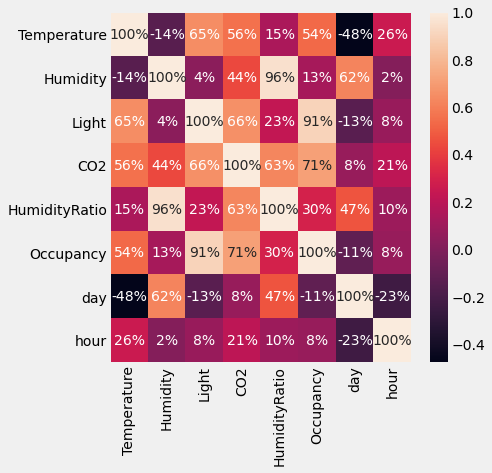

In [9]:
plt.subplots(figsize=(6, 6))
sns.heatmap(training_table.corr(), annot=True, fmt=".0%")

In [10]:
training_table = training_table.drop("day", axis=1)
training_table = training_table.drop("hour", axis=1)

In [11]:
SEQ_LEN = 5
NUM_FEAT = 5
DROP = 0.5

In [12]:
scaler = RobustScaler()

In [13]:
X_train = training_table.drop("Occupancy", axis=1).values
Y_train = training_table["Occupancy"].values
X_train = scaler.fit_transform(X_train, Y_train)
training_sequence = [(X_train[i:i+SEQ_LEN, :], Y_train[i+SEQ_LEN]) for i in range(0, len(X_train) - SEQ_LEN)]
N = len(Y_train)

In [14]:
train_set, test_set = train_test_split(training_sequence, test_size=0.3, shuffle=True)
train_dl = torch.utils.data.DataLoader(train_set, batch_size=200, shuffle=True, num_workers=2)
val_dl = torch.utils.data.DataLoader(test_set, batch_size=200, shuffle=True, num_workers=2)

In [15]:
class Net(nn.Module, MCSingleMixin):
    def __init__(self):
        super(Net, self).__init__()
        self.rnn = StochasticLSTM(NUM_FEAT, 50, dropout=DROP)
        self.fc1 = nn.Linear(50, 25)
        self.fc2 = nn.Linear(25, 1)
    
    def regularizer(self):        
        return 0.
    
    def get_output_shape(self, x: torch.Tensor):
        B = x.shape[1]
        return (B,)
    
    def forward(self, x):
        result, _ = self.rnn(x)
        result = torch.tanh(result[-1,:])
        result = torch.relu(self.fc1(result))
        result = self.fc2(result).flatten()
        return result

In [16]:
net = Net()
criterion = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(net.parameters(), lr=1e-3)

In [17]:
metrics = [BCLogitMetric()]

In [18]:
%%time
net = train_model(net, train_dl, val_dl, criterion, optimizer, "occupancy-0.5.pt", 100, metrics=metrics, patience=5)

[1, 100.00%] train loss: 0.672282
[1, 100.00%] validate loss: 0.556103
Accuracy = 0.893
[2, 100.00%] train loss: 0.357640
[2, 100.00%] validate loss: 0.281861
Accuracy = 0.901
[3, 100.00%] train loss: 0.245881
[3, 100.00%] validate loss: 0.216952
Accuracy = 0.905
[4, 100.00%] train loss: 0.221325
[4, 100.00%] validate loss: 0.188640
Accuracy = 0.909
[5, 100.00%] train loss: 0.192593
[5, 100.00%] validate loss: 0.184953
Accuracy = 0.913
[6, 100.00%] train loss: 0.169279
[6, 100.00%] validate loss: 0.164512
Accuracy = 0.917
[7, 100.00%] train loss: 0.153531
[7, 100.00%] validate loss: 0.165139
Accuracy = 0.921
Retry 1/5
[8, 100.00%] train loss: 0.147625
[8, 100.00%] validate loss: 0.142974
Accuracy = 0.925
[9, 100.00%] train loss: 0.144439
[9, 100.00%] validate loss: 0.137934
Accuracy = 0.929
[10, 100.00%] train loss: 0.135500
[10, 100.00%] validate loss: 0.128704
Accuracy = 0.931
[11, 100.00%] train loss: 0.124921
[11, 100.00%] validate loss: 0.116364
Accuracy = 0.934
[12, 100.00%] trai

## Test

In [19]:
test_table = pd.read_csv("./data/occupancy_data/datatest.txt")
test_table = test_table.drop("date", axis=1)
test_table = test_table.astype(np.float32)

In [20]:
X_test = test_table.drop("Occupancy", axis=1).values
X_test = scaler.transform(X_test)
X_test = np.array([X_test[i:i+SEQ_LEN, :] for i in range(0, len(X_test) - SEQ_LEN)])
X_test = X_test.swapaxes(1, 0)
Y_test = test_table["Occupancy"].values[SEQ_LEN:]
X_test = torch.tensor(X_test)

In [21]:
net.eval()
with torch.no_grad():
    outputs = net.sample(10, X_test)
    outputs = torch.sigmoid(outputs)
    uncertainties = uncertainty_avg(outputs)
    predictions = score_avg(outputs)

In [22]:
roc_auc_score(Y_test, predictions)

0.9835749246700477

In [23]:
accuracy_score(Y_test, torch.round(predictions))

0.9669172932330827

In [24]:
precision_score(Y_test, torch.round(predictions))

0.9238187078109933

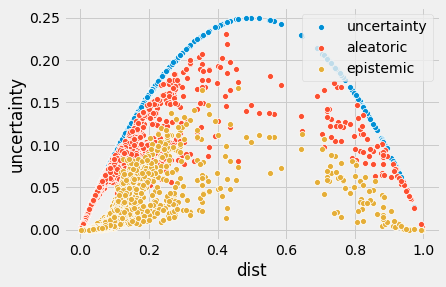

In [25]:
dist = torch.abs(predictions - Y_test)
A = aleatoric_uncertainty(outputs)
E = epistemic_uncertainty(outputs)

sns.scatterplot(x=dist, y=uncertainties)
sns.scatterplot(x=dist, y=A)
sns.scatterplot(x=dist, y=E)
plt.xlabel("dist")
plt.ylabel("uncertainty")
plt.legend(labels=['uncertainty', 'aleatoric', 'epistemic'])

### Spread analysis for misclassification

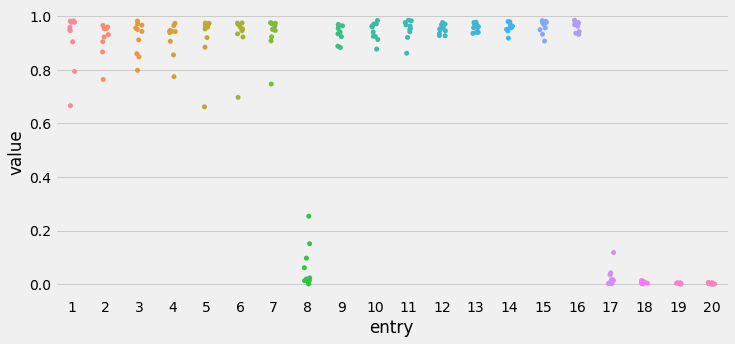

In [26]:
T, B = outputs.shape[0:2]
post_sigmoid_df = pd.DataFrame(columns=["entry","value"])
for i in range(T):
    for j, idx in enumerate(dist.argsort()[-20:]):
        post_sigmoid_df.loc[i*B + j] = (j+1, outputs[i,idx])

plot = sns.catplot(x="entry", y="value", data=post_sigmoid_df)
plot.fig.set_figwidth(12)

### Spread analysis for correct classification

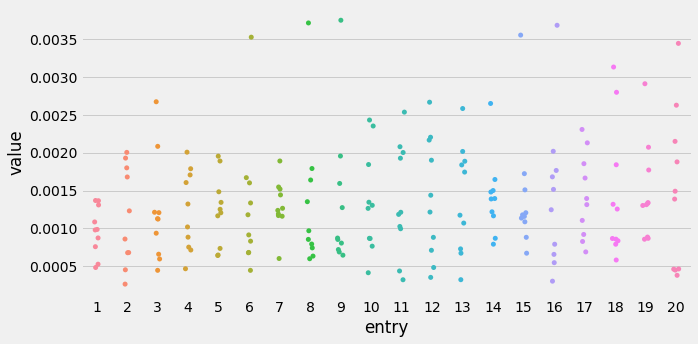

In [27]:
T, B = outputs.shape[0:2]
post_sigmoid_df = pd.DataFrame(columns=["entry","value"])
for i in range(T):
    for j, idx in enumerate(dist.argsort()[:20]):
        post_sigmoid_df.loc[i*B + j] = (j+1, outputs[i,idx])

plot = sns.catplot(x="entry", y="value", data=post_sigmoid_df)
plot.fig.set_figwidth(12)